In [1]:

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools

print(" TensorFlow version:", tf.__version__)

from google.colab import drive
drive.mount('/content/drive')


 TensorFlow version: 2.19.0
Mounted at /content/drive


In [2]:

DRIVE_ZIP_PATH = "/content/drive/MyDrive/Indian Bovine Classification Dataset.zip"
EXTRACT_TO = "/content/ib_dataset"

if not os.path.exists(os.path.join(EXTRACT_TO, "Indian_bovine_breeds")):
    print("Unzipping dataset... ⏳")
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_TO)
    print("✅ Dataset unzipped.")
else:
    print("✅ Dataset already unzipped.")

# Dataset root folder
DATA_DIR = os.path.join(EXTRACT_TO, "Indian_bovine_breeds")
assert os.path.exists(DATA_DIR), f"❌ Dataset not found at {DATA_DIR}"

# List classes (breeds)
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(classes)

print(f"✅ Found {NUM_CLASSES} breed classes.")
print("Sample classes:", classes[:10])


Unzipping dataset... ⏳
✅ Dataset unzipped.
✅ Found 41 breed classes.
Sample classes: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur', 'Bhadawari', 'Brown_Swiss', 'Dangi', 'Deoni', 'Gir']


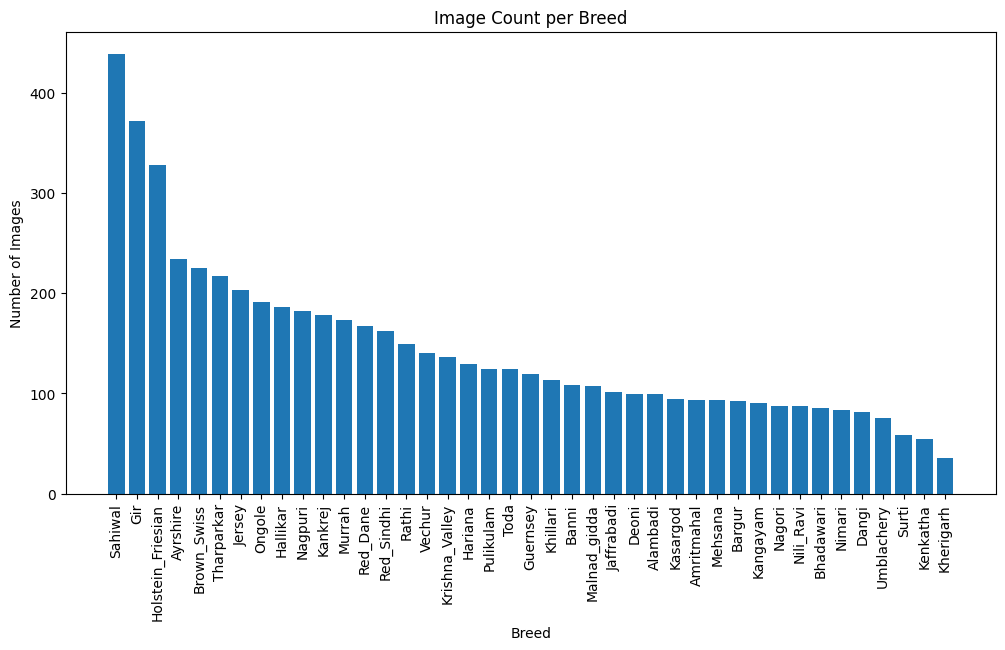

✅ Dataset Distribution Summary:
       ImageCount
count   41.000000
mean   144.536585
std     83.246050
min     36.000000
25%     93.000000
50%    119.000000
75%    178.000000
max    439.000000


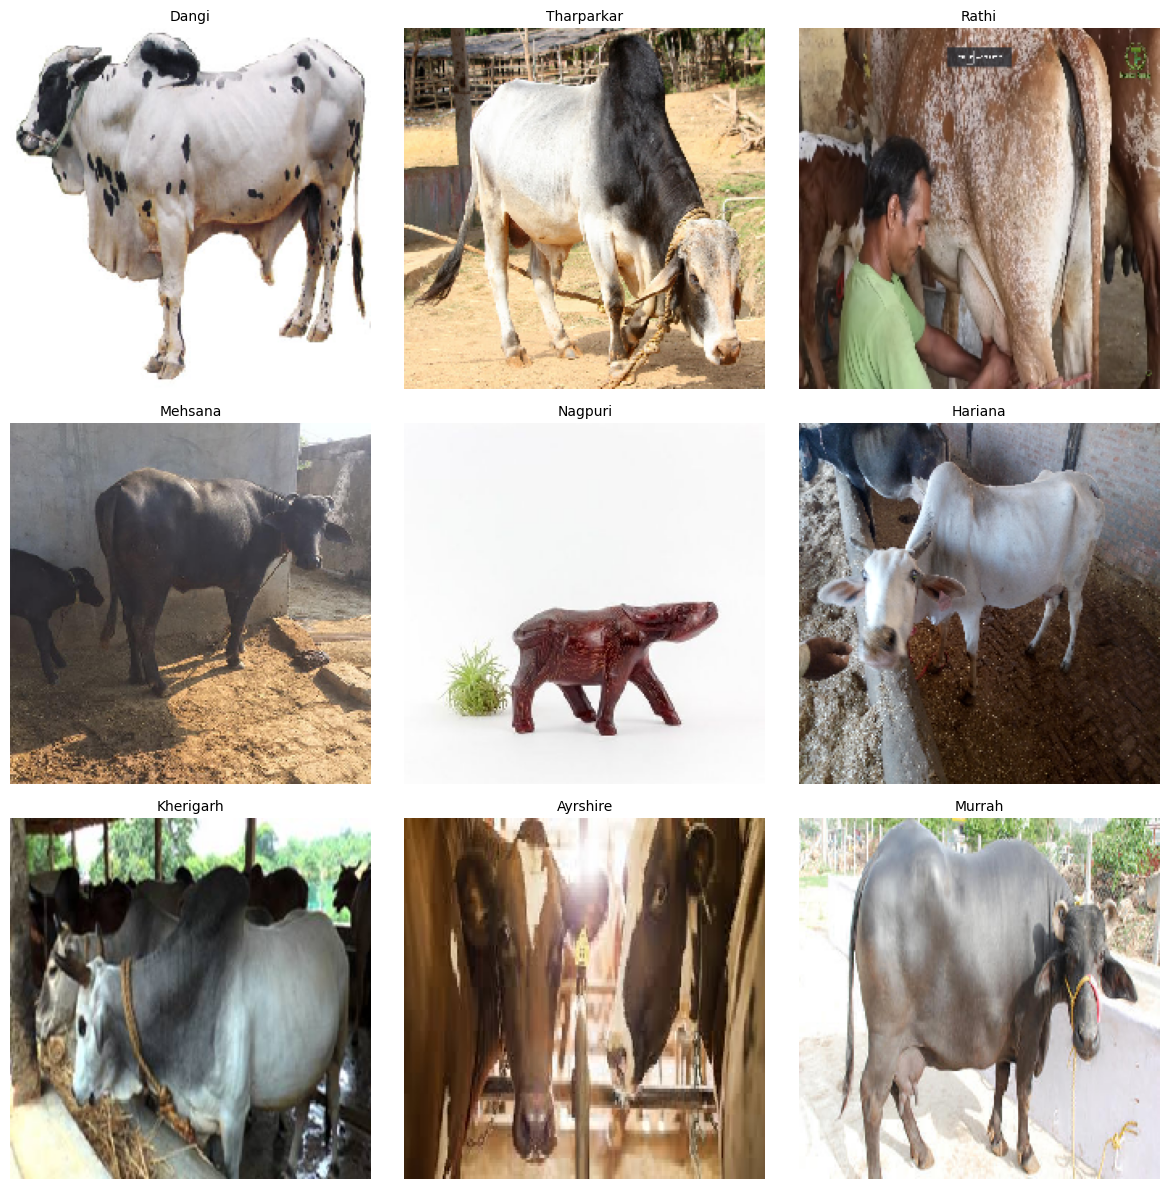

In [3]:

import pandas as pd
from collections import Counter

class_counts = {}
for cls in classes:
    path = os.path.join(DATA_DIR, cls)
    n_images = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    class_counts[cls] = n_images

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Breed", "ImageCount"]).sort_values(by="ImageCount", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_counts["Breed"], df_counts["ImageCount"])
plt.xticks(rotation=90)
plt.title("Image Count per Breed")
plt.xlabel("Breed")
plt.ylabel("Number of Images")
plt.show()

print("✅ Dataset Distribution Summary:")
print(df_counts.describe())

# Show sample images from 9 random classes
def show_sample_images(n=9):
    plt.figure(figsize=(12, 12))
    sample_classes = random.sample(classes, n)
    for i, cls in enumerate(sample_classes, 1):
        img_files = [f for f in os.listdir(os.path.join(DATA_DIR, cls)) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        img_path = os.path.join(DATA_DIR, cls, random.choice(img_files))
        img = keras.utils.load_img(img_path, target_size=(224,224))
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.title(cls, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images()


In [4]:

SPLIT_ROOT = "/content/ib_split"
train_dir = os.path.join(SPLIT_ROOT, "train")
val_dir = os.path.join(SPLIT_ROOT, "val")

if not os.path.exists(SPLIT_ROOT):
    print("📂 Creating stratified train/val split (80/20)...")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for cls in classes:
        src = os.path.join(DATA_DIR, cls)
        fnames = [f for f in os.listdir(src) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        random.shuffle(fnames)
        n_total = len(fnames)
        n_train = int(0.8 * n_total)
        train_files, val_files = fnames[:n_train], fnames[n_train:]

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        for f in train_files:
            shutil.copy(os.path.join(src, f), os.path.join(train_dir, cls, f))
        for f in val_files:
            shutil.copy(os.path.join(src, f), os.path.join(val_dir, cls, f))

    print("✅ Train/Val split created.")
else:
    print("✅ Split already exists, skipping.")

train_classes = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]
val_classes = [len(os.listdir(os.path.join(val_dir, cls))) for cls in classes]
print(f"Train images: {sum(train_classes)}, Val images: {sum(val_classes)}")


📂 Creating stratified train/val split (80/20)...
✅ Train/Val split created.
Train images: 4724, Val images: 1202


In [5]:

from tensorflow.keras import layers

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                    num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

print("✅ Data pipeline ready:")
print(f"- Train batches: {len(train_ds)}")
print(f"- Validation batches: {len(val_ds)}")


Found 4724 files belonging to 41 classes.
Found 1202 files belonging to 41 classes.
✅ Data pipeline ready:
- Train batches: 148
- Validation batches: 38


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


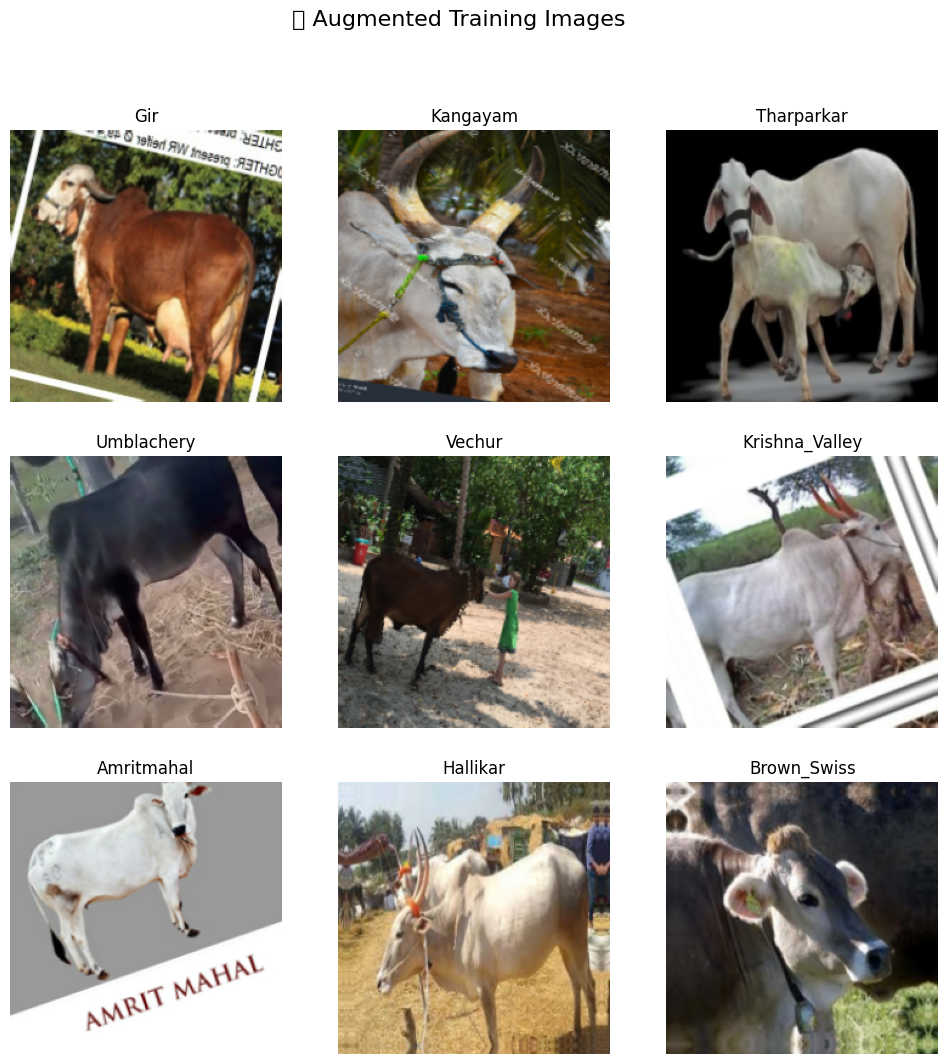

In [6]:

import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    label = classes[label_batch[i].numpy()]
    plt.title(label)
    plt.axis("off")
plt.suptitle("📸 Augmented Training Images", fontsize=16)
plt.show()


In [7]:

IMG_HEIGHT, IMG_WIDTH = 224, 224

from tensorflow.keras import applications, layers, models

# MobileNetV3Large backbone
base_model = applications.MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)


base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 41)             │        39,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,039,593 (11.60 MB)

 Trainable params: 41,321 (161.41 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [8]:

!pip install ultralytics -q

from ultralytics import YOLO
import cv2
import numpy as np
import os
from tqdm import tqdm

print("✅ YOLOv8 installed successfully")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ YOLOv8 installed successfully


In [9]:

detector = YOLO("yolov8n.pt")

CLEAN_DATASET = "/content/ib_dataset_clean"
os.makedirs(CLEAN_DATASET, exist_ok=True)

for breed in tqdm(classes, desc="Processing breeds"):
    breed_path = os.path.join(DATA_DIR, breed)
    save_path = os.path.join(CLEAN_DATASET, breed)
    os.makedirs(save_path, exist_ok=True)

    for img_name in os.listdir(breed_path):
        img_path = os.path.join(breed_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue


            results = detector(img, verbose=False)

            if len(results[0].boxes) > 0:
                areas = []
                for box in results[0].boxes.xyxy:
                    x1, y1, x2, y2 = map(int, box[:4])
                    areas.append((x2-x1)*(y2-y1))
                best_idx = np.argmax(areas)
                x1, y1, x2, y2 = map(int, results[0].boxes.xyxy[best_idx])

                cropped = img[y1:y2, x1:x2]

                cropped = cv2.resize(cropped, (IMG_WIDTH, IMG_HEIGHT))

                save_file = os.path.join(save_path, img_name)
                cv2.imwrite(save_file, cropped)
        except:
            continue

print("✅ All cows cropped & saved in:", CLEAN_DATASET)


Processing breeds: 100%|██████████| 41/41 [03:04<00:00,  4.51s/it]

✅ All cows cropped & saved in: /content/ib_dataset_clean


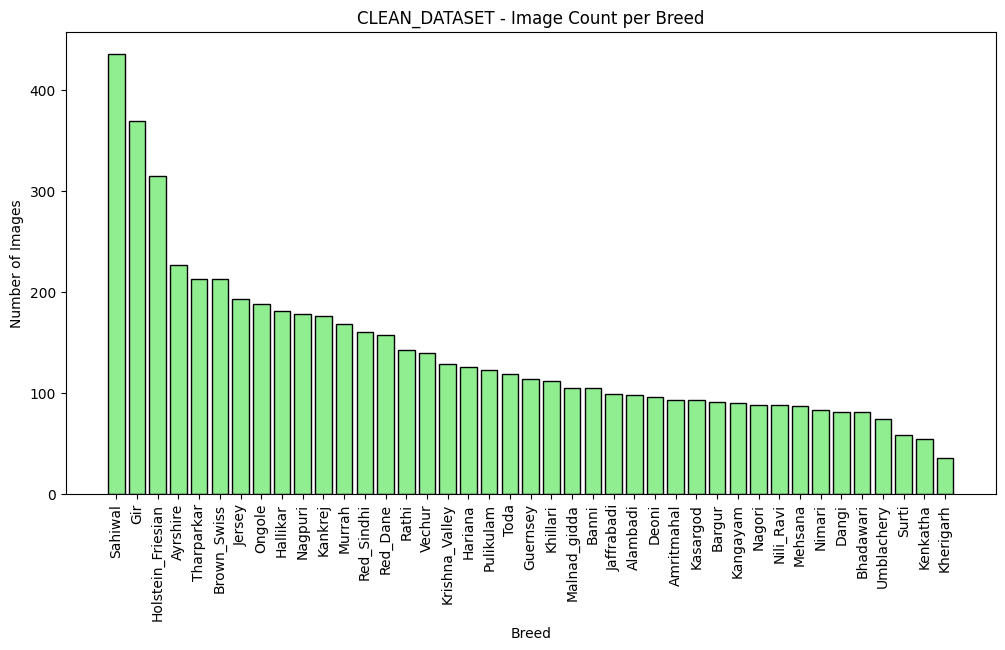

✅ CLEAN_DATASET Distribution Summary:
       ImageCount
count   41.000000
mean   140.902439
std     81.773102
min     35.000000
25%     90.000000
50%    114.000000
75%    176.000000
max    436.000000
Suggested class weights for training: {0: 63.48351648351648, 1: 30.72872340425532, 2: 29.932642487046632, 3: 46.96747967479675, 4: 15.655826558265582, 5: 13.25, 6: 60.177083333333336, 7: 41.56115107913669, 8: 62.11827956989247, 9: 66.40229885057471, 10: 40.683098591549296, 11: 25.449339207048457, 12: 31.917127071823206, 13: 165.05714285714285, 14: 27.122065727699532, 15: 64.18888888888888, 16: 58.35353535353536, 17: 71.32098765432099, 18: 34.38690476190476, 19: 18.33968253968254, 20: 62.11827956989247, 21: 36.796178343949045, 22: 69.60240963855422, 23: 65.64772727272727, 24: 65.64772727272727, 25: 55.01904761904762, 26: 106.98148148148148, 27: 27.122065727699532, 28: 55.01904761904762, 29: 32.82386363636363, 30: 99.60344827586206, 31: 44.78294573643411, 32: 50.675438596491226, 33: 48.54621

In [10]:

import pandas as pd
from collections import Counter

clean_class_counts = {}
for cls in os.listdir(CLEAN_DATASET):
    path = os.path.join(CLEAN_DATASET, cls)
    if os.path.isdir(path):
        n_images = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        clean_class_counts[cls] = n_images

df_clean_counts = pd.DataFrame(list(clean_class_counts.items()), columns=["Breed", "ImageCount"]).sort_values(by="ImageCount", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_clean_counts["Breed"], df_clean_counts["ImageCount"], color="lightgreen", edgecolor="black")
plt.xticks(rotation=90)
plt.title("CLEAN_DATASET - Image Count per Breed")
plt.xlabel("Breed")
plt.ylabel("Number of Images")
plt.show()

print("✅ CLEAN_DATASET Distribution Summary:")
print(df_clean_counts.describe())

total = sum(clean_class_counts.values())
class_weights = {i: total/count for i, (cls, count) in enumerate(clean_class_counts.items())}
print("Suggested class weights for training:", class_weights)


max_count = max(clean_class_counts.values())
for cls, count in clean_class_counts.items():
    if count < max_count:
        src_dir = os.path.join(CLEAN_DATASET, cls)
        imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        needed = max_count - count
        print(f"Oversampling {cls}: need {needed} more images")

        for i in range(needed):
            img_name = imgs[i % len(imgs)]
            src_path = os.path.join(src_dir, img_name)
            dst_path = os.path.join(src_dir, f"aug_{i}_{img_name}")
            shutil.copy(src_path, dst_path)

print("✅ CLEAN_DATASET balanced with oversampling (if enabled).")


In [11]:

from tensorflow.keras.utils import image_dataset_from_directory

CLEAN_DATA_DIR = CLEAN_DATASET

train_ds_clean = image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds_clean = image_dataset_from_directory(
    CLEAN_DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_clean = train_ds_clean.prefetch(buffer_size=AUTOTUNE)
val_ds_clean = val_ds_clean.prefetch(buffer_size=AUTOTUNE)

print("✅ Clean train/val datasets ready")


Found 17896 files belonging to 41 classes.
Using 14317 files for training.
Found 17896 files belonging to 41 classes.
Using 3579 files for validation.
✅ Clean train/val datasets ready


In [12]:
# MobileNetV3Large backbone
base_model = applications.MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_clean = models.Model(inputs, outputs)

model_clean.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_WARMUP = 15
history_clean = model_clean.fit(
    train_ds_clean,
    validation_data=val_ds_clean,
    epochs=EPOCHS_WARMUP
)


Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.2145 - loss: 3.2014 - val_accuracy: 0.5384 - val_loss: 1.6702
Epoch 2/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.4818 - loss: 1.7822 - val_accuracy: 0.6080 - val_loss: 1.4040
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.5461 - loss: 1.5381 - val_accuracy: 0.6429 - val_loss: 1.2706
Epoch 4/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.5901 - loss: 1.3828 - val_accuracy: 0.6737 - val_loss: 1.1822
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6055 - loss: 1.3088 - val_accuracy: 0.6790 - val_loss: 1.1314
Epoch 6/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.6157 - loss: 1.2526 - val_accuracy: 0.6954 - val_loss: 1.0888
Epoch 7/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6215 - loss: 1.2361 - val_accuracy: 0.6935 - val_loss: 1.0566
Epoch 8/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.6285 - loss: 1.2243 - 

In [13]:

base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model_clean.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_FINE = 30
history_fine_clean = model_clean.fit(
    train_ds_clean,
    validation_data=val_ds_clean,
    epochs=EPOCHS_FINE
)


Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - accuracy: 0.4930 - loss: 1.7560 - val_accuracy: 0.6826 - val_loss: 1.1279
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.5579 - loss: 1.5030 - val_accuracy: 0.7022 - val_loss: 1.0409
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.5859 - loss: 1.3577 - val_accuracy: 0.7130 - val_loss: 0.9844
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.6230 - loss: 1.2486 - val_accuracy: 0.7220 - val_loss: 0.9485
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.6376 - loss: 1.1700 - val_accuracy: 0.7343 - val_loss: 0.9146
Epoch 6/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.6614 - loss: 1.0793 - val_accuracy: 0.7379 - val_loss: 0.8850
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.6724 - loss: 1.0396 - val_accuracy: 0.7494 - val_loss: 0.8548
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.6890 - loss: 0

In [14]:


SAVE_DIR = "/content/drive/MyDrive/indian_breed_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ Option 1: Recommended Keras v3 format
model_clean.save(os.path.join(SAVE_DIR, "indian_breed_model.keras"))

# ✅ Option 2: HDF5 format (for older compatibility)
model_clean.save(os.path.join(SAVE_DIR, "indian_breed_model.h5"))

# ✅ Option 3: TensorFlow SavedModel (for TF Serving / TFLite export)
model_clean.export(os.path.join(SAVE_DIR, "indian_breed_savedmodel"))

print("✅ Model saved in 3 formats at:", SAVE_DIR)



Saved artifact at '/content/drive/MyDrive/indian_breed_model/indian_breed_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_417')
Output Type:
  TensorSpec(shape=(None, 41), dtype=tf.float32, name=None)
Captures:
  132372714005776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132372714008272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132372714004048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930705936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930706128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930707088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930706704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930706896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930705168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132369930706320: TensorSpec(sh

Loading model from: /content/drive/MyDrive/indian_breed_model/indian_breed_model.keras
✅ Model loaded successfully
Classes: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur', 'Bhadawari', 'Brown_Swiss', 'Dangi', 'Deoni', 'Gir', 'Guernsey', 'Hallikar', 'Hariana', 'Holstein_Friesian', 'Jaffrabadi', 'Jersey', 'Kangayam', 'Kankrej', 'Kasargod', 'Kenkatha', 'Kherigarh', 'Khillari', 'Krishna_Valley', 'Malnad_gidda', 'Mehsana', 'Murrah', 'Nagori', 'Nagpuri', 'Nili_Ravi', 'Nimari', 'Ongole', 'Pulikulam', 'Rathi', 'Red_Dane', 'Red_Sindhi', 'Sahiwal', 'Surti', 'Tharparkar', 'Toda', 'Umblachery', 'Vechur']


Saving images.jpeg to images.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


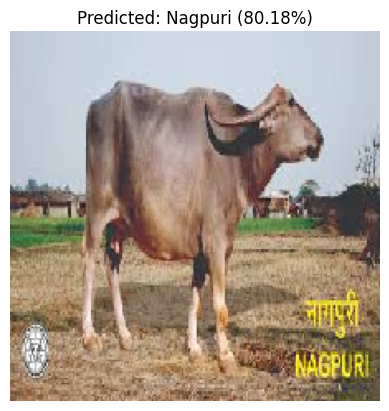

✅ Prediction: Nagpuri with 80.18% confidence


In [15]:


from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

MODEL_PATH = "/content/drive/MyDrive/indian_breed_model/indian_breed_model.keras"
# MODEL_PATH = "/content/drive/MyDrive/indian_breed_model/indian_breed_model.h5"
# MODEL_PATH = "/content/drive/MyDrive/indian_breed_model/indian_breed_savedmodel"

print(f"Loading model from: {MODEL_PATH}")
model_loaded = keras.models.load_model(MODEL_PATH)

if 'classes' not in globals():
    CLEAN_DATASET = "/content/ib_dataset_clean"
    classes = sorted([d for d in os.listdir(CLEAN_DATASET) if os.path.isdir(os.path.join(CLEAN_DATASET, d))])

print("✅ Model loaded successfully")
print("Classes:", classes)

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn

    img = keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # batch dim

    preds = model_loaded.predict(img_array)
    pred_idx = np.argmax(preds[0])
    confidence = preds[0][pred_idx]

    predicted_class = classes[pred_idx]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    print(f"✅ Prediction: {predicted_class} with {confidence*100:.2f}% confidence")


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the model's prediction layers
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of class wrt feature maps
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients over width and height
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by “how important this channel is”
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name="Conv_1", alpha=0.4):
    # Preprocess image
    img = keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to image size
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.img_to_array(
        keras.utils.array_to_img(jet_heatmap).resize((img.shape[1], img.shape[0]))
    )
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Show
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Explanation")
    plt.show()


In [20]:
display_gradcam(img_path, model_loaded, last_conv_layer_name="MobileNetV3Large")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_4']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


KeyError: "Exception encountered when calling Functional.call().\n\n\x1b[1m132369888736656\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[     0.7451,     0.78431,     0.83137],\n         [     0.7451,     0.78431,     0.83137],\n         [    0.74902,     0.78824,     0.83529],\n         ...,\n         [    0.76078,         0.8,     0.84706],\n         [    0.75686,     0.79608,     0.84314],\n         [    0.75686,     0.79608,     0.84314]],\n\n        [[     0.7451,     0.78431,     0.83137],\n         [     0.7451,     0.78431,     0.83137],\n         [    0.74902,     0.78824,     0.83529],\n         ...,\n         [    0.76078,         0.8,     0.84706],\n         [    0.75686,     0.79608,     0.84314],\n         [    0.75686,     0.79608,     0.84314]],\n\n        [[     0.7451,     0.78431,     0.83137],\n         [     0.7451,     0.78431,     0.83137],\n         [    0.74902,     0.78824,     0.83529],\n         ...,\n         [    0.76078,         0.8,     0.84706],\n         [    0.75686,     0.79608,     0.84314],\n         [    0.75686,     0.79608,     0.84314]],\n\n        ...,\n\n        [[    0.52941,     0.36863,      0.2902],\n         [    0.50196,     0.35294,     0.26275],\n         [    0.52157,     0.38039,     0.28627],\n         ...,\n         [    0.41569,     0.36863,     0.26667],\n         [    0.40392,     0.35686,      0.2549],\n         [    0.38431,     0.33725,     0.25098]],\n\n        [[    0.52941,     0.36863,      0.2902],\n         [    0.50196,     0.35294,     0.26275],\n         [    0.52157,     0.38039,     0.28627],\n         ...,\n         [    0.41569,     0.36863,     0.26667],\n         [    0.40392,     0.35686,      0.2549],\n         [    0.38431,     0.33725,     0.25098]],\n\n        [[    0.48235,     0.32157,     0.25098],\n         [    0.47059,     0.32157,     0.23922],\n         [    0.48627,      0.3451,     0.25098],\n         ...,\n         [    0.34118,     0.30196,     0.19608],\n         [    0.34902,      0.3098,     0.20392],\n         [    0.36471,     0.32157,     0.24314]]]], dtype=float32)\n  • training=None\n  • mask=None\n  • kwargs=<class 'inspect._empty'>"